# Exercise 1:

The notebook will guide through some basic details of Sentinel-1 and Sentinel-2 data:

    * Different sensor characteristics
    * How to search and preview data
    * Main aspects to consider when dealing with Sentinel-1 data
    
TODO: Add Reference to H2020-BETTER Project

# Sentinel-1 and Sentinel-2

Free and Open Data Policy: [scihub](https://scihub.copernicus.eu/)

TODO: In BETTER we use cloud appliances to get data at scale

## [Sentinel-1](https://en.wikipedia.org/wiki/Sentinel-1)

* A constellation of two satellites, Sentinel-1A and Sentinel-1B
* C-band synthetic-aperture radar (SAR)
* Collection of data in all-weather, day or night
* Spatial resolution of down to 5 m and a swath of up to 400 km
* Sun synchronous, near-polar (98.18°) orbit
* The orbit has a 12-day repeat cycle

## [Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2)

* A constallation of two twin satellites, Sentinel-2A and Sentinel-2B
* Multi-spectral data with 13 bands in the visible, near infrared, and short wave infrared part of the spectrum
* Systematic global coverage of land surfaces from 56° S to 84° N, coastal waters, and all of the Mediterranean Sea
* High spatial resolution (10 m to 60 m). 290 km field of view
* The orbit is Sun synchronous at 786 km (488 mi) altitude
* Revisiting every 10 days under the same viewing angles. At high latitudes, Sentinel-2 swath overlap and some regions will be observed twice or more every 10 days, but with different viewing angles

## Example Searching and previewing a Sentinel-1 and Sentinel-2 image

Installing some libraries to interact with ESA Scihub

In [ ]:
!/opt/anaconda/envs/env_better/bin/pip3 install sentinelsat folium shapely

### Defining a certain area of interest 

In [ ]:
import folium
from sentinelsat import SentinelAPI
import shapely.wkt
import pandas as pd
import geopandas

wkt = 'POLYGON((-4.430811972177363 36.69549864402423,-4.399230541551978 36.69549864402423,-4.399230541551978 36.72132011062699,-4.430811972177363 36.72132011062699,-4.430811972177363 36.69549864402423))'
geojson = shapely.wkt.loads(wkt)

m = folium.Map([36.69, -4.4], zoom_start=13)
folium.GeoJson(geojson, name='AOI').add_to(m)
folium.LayerControl().add_to(m)
m

The Scihub service needs credentials to access to the data, but an account can be created for free --> [Scihub](https://scihub.copernicus.eu/)

In [ ]:
import getpass

user = 'obarrile'
password = getpass.getpass() 

In [ ]:
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
dates = ('20201014', '20201018')
productsS2 = api.query(wkt,
                     date = dates,
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 20))

productsS1 = api.query(wkt,
                     date = dates,
                     platformname = 'Sentinel-1',
                     producttype = 'GRD')



S2_data = api.to_geojson(productsS2)
S2_gdf = api.to_geodataframe(productsS2)
S1_data = api.to_geojson(productsS1)
S1_gdf = api.to_geodataframe(productsS1)
products_gdf = pd.concat([S1_gdf, S2_gdf])
products_gdf

Display the locations of returned results in the map

In [ ]:
style_me = lambda feature: {
        'fillOpacity': 0.3,
        'weight': 1,
        'fillColor': '#FF0000' if 'S2' in feature['properties']['title'] else '#00FF00'
    }


m = folium.Map([36.69, -4.4], zoom_start=8)
folium.GeoJson(geojson, name='AOI').add_to(m)
s1_folium = folium.GeoJson(data = S1_gdf[['geometry','title','link_icon']], 
               style_function = style_me,
               name = 'Sentinel-1 products',
               ).add_to(m)
s2_folium = folium.GeoJson(data = S2_gdf[['geometry','title','link_icon']], 
               style_function = style_me,
               name='Sentinel-2 products',
               ).add_to(m)

folium.LayerControl().add_to(m)
m

Filter only products at a specific date

In [ ]:
import datetime

date_of_interest = '15-10-2020'

filtered_gdf = products_gdf[products_gdf['beginposition'].apply( lambda d: d.date() == datetime.datetime.strptime(date_of_interest,'%d-%m-%Y').date())]
filtered_gdf

Display the quicklooks in the map to compare the differences

In [ ]:
import io
import requests
import numpy as np
from scipy.ndimage import rotate
from requests.auth import HTTPBasicAuth
from PIL import Image

m = folium.Map([36.69, -4.4], zoom_start=8)

for i, row in filtered_gdf.iterrows():
    quicklook_query = requests.get(row['link_icon'], auth=HTTPBasicAuth(user,password))
    img_data = np.asarray(Image.open(io.BytesIO(quicklook_query.content)))
    #print(img_data)
    bounds = row['geometry'].bounds
    img = folium.raster_layers.ImageOverlay(
        name=row['title'],
        # FIXME: This is just an example for visualization purposes, 
        #        it does not generalise to all acquisitions
        image=img_data if 'S2' in row['title'] else rotate(img_data, -10, reshape=True), 
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
        opacity=0.5)
    #print(row['geometry'].bounds)
    img.add_to(m)
    

folium.GeoJson(geojson, name='AOI').add_to(m)
folium.LayerControl().add_to(m)
m
    

## Optical image example

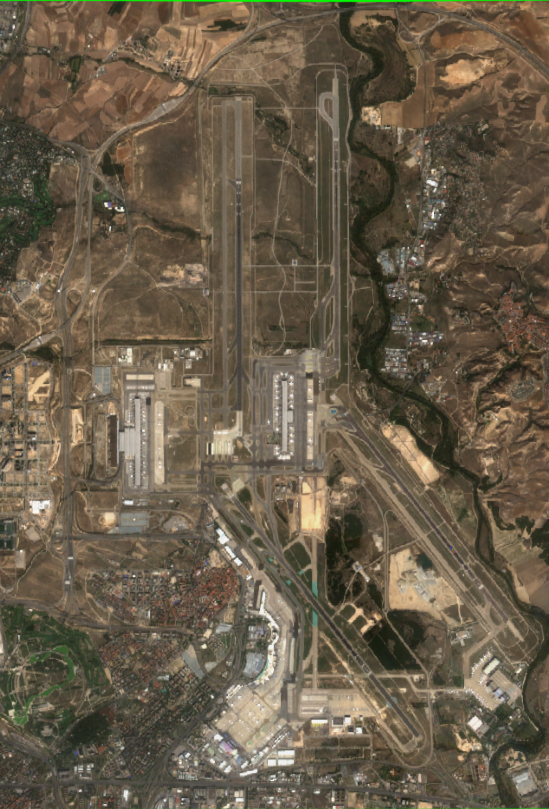 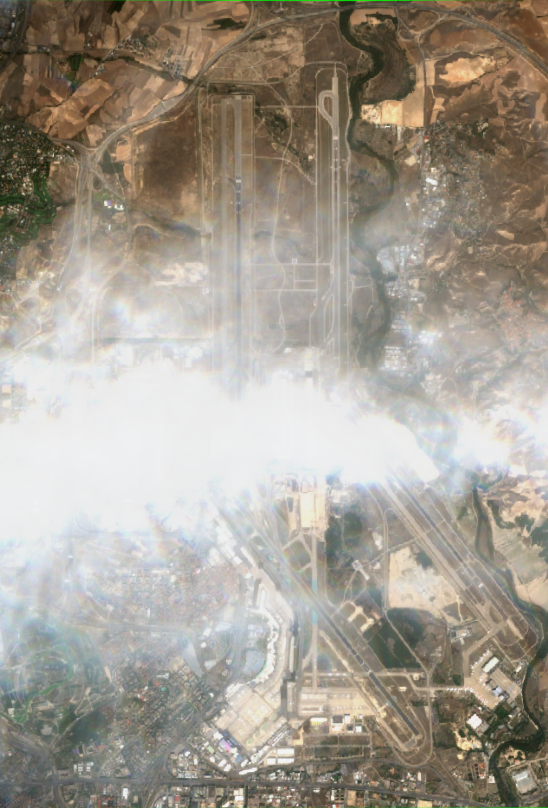 

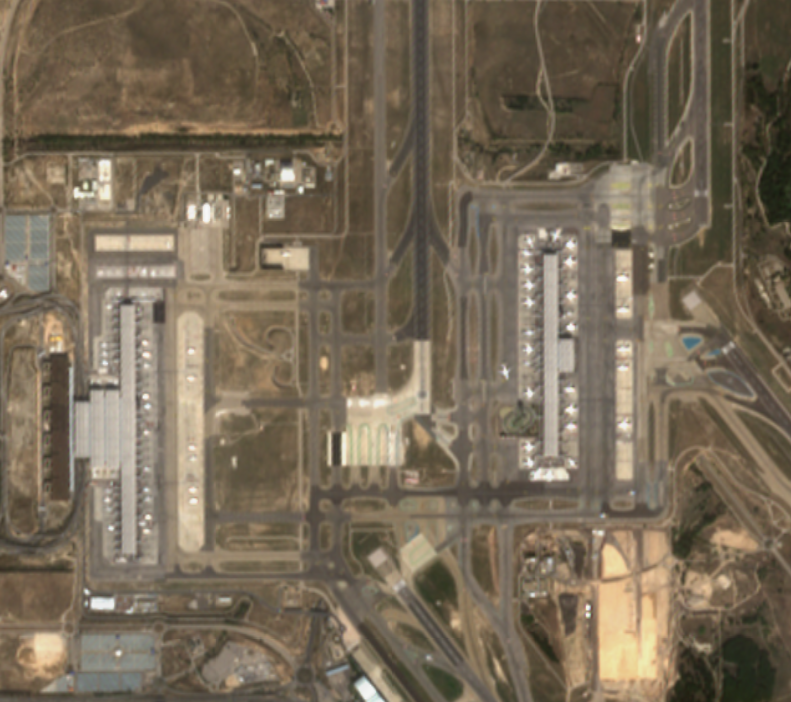 

## Proposed Exercise:

   * [ ] Create an account in Scihub
   * [ ] Browse the documentation of [sentinelsat library](https://sentinelsat.readthedocs.io/en/stable/)
   * [ ] Search for a Sentinel-2 L2A scene on your Area
   * [ ] Visualize the preview